In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import datetime, time
import mpl_finance as mpf #替换 import matplotlib.finance as mpf
import matplotlib.gridspec as gridspec#分割子图
import baostock as bs
import talib

In [2]:
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

```
fig = plt.figure(figsize=(14,5), dpi=100, facecolor='w')
graph_sma = fig.add_subplot(1,1,1)

graph_sma.plot(np.arange(0, len(stock_dat.index)), stock_dat['SMA20'], 'black', label='SMA20', lw=1.0)
graph_sma.plot(np.arange(0, len(stock_dat.index)), stock_dat['SMA30'], 'black', label='green', lw=1.0)
graph_sma.plot(np.arange(0, len(stock_dat.index)), stock_dat['SMA60'], 'black', label='blue', lw=1.0)

graph_sma.legend(loc=0)
graph_sma.set_title(u'000651格力电器-均线')
graph_sma.set_ylabel(u'价格')
graph_sma.set_xlim(o, len(stock_dat.index))
graph_sma.set_xticks(range(0,len(stock_dat.index), 15))
graph_sma.set_xtickslabels([stock_dat.index.strftime(%Y-%m-%d')[index]\
                            for index in graph_sma.get_xticks()])
                                                     
fig.autofmt_xdate(rotation=45)

```

## 定制可视化接口

### 可视化接口框架的实现

In [3]:
class DefTypesPool():

    def __init__(self):
        self.routes = {}

    def route_types(self, types_str):
        def decorator(f):
            self.routes[types_str] = f
            return f
        return decorator

    def route_output(self, path):
        #print(u"output [%s] function:" % path)
        function_val = self.routes.get(path)
        if function_val:
            return function_val
        else:
            raise ValueError('Route "{}"" has not been registered'.format(path))

In [4]:
class MplTypesDraw():

    mpl = DefTypesPool()

    @mpl.route_types(u"line")
    def line_plot(df_index, df_dat, graph):
        # 绘制line图
        for key, val in df_dat.items():
            graph.plot(np.arange(0, len(val)), val, label=key, lw=1.0)

    @mpl.route_types(u"ochl")
    def ochl_plot(df_index, df_dat, graph):
        # 绘制ochl图——Kline
        # 方案一
        mpf.candlestick2_ochl(graph, df_dat['Open'], df_dat['Close'], df_dat['High'], df_dat['Low'], width=0.5,
                              colorup='r', colordown='g') # 绘制K线走势
        # 方案二
        ohlc = list(zip(np.arange(0,len(df_index)),df_dat['Open'], df_dat['Close'], df_dat['High'], df_dat['Low'])) # 使用zip方法生成数据列表
        mpf.candlestick_ochl(graph, ohlc, width=0.2, colorup='r', colordown='g', alpha=1.0) # 绘制K线走势

    @mpl.route_types(u"bar")
    def bar_plot(df_index, df_dat, graph):
        # 绘制bar图——Volume
        #graph.bar(np.arange(0, len(df_index)), df_dat['Volume'], \
        #         color=['g' if df_dat['Open'][x] > df_dat['Close'][x] else 'r' for x in range(0,len(df_index))])

        graph.bar(np.arange(0, len(df_index)), df_dat['bar_red'], facecolor='red')
        graph.bar(np.arange(0, len(df_index)), df_dat['bar_green'], facecolor='green')

    @mpl.route_types(u"hline")
    def hline_plot(df_index, df_dat, graph):
        # 绘制hline图
        for key, val in df_dat.items():
            graph.axhline(val['pos'], c=val['c'], label=key)

    @mpl.route_types(u"annotate")
    def annotate_plot(df_index, df_dat, graph):
        # 绘制annotate图
        for key, val in df_dat.items():
            for kl_index, today in val['andata'].iterrows():
                x_posit = df_index.get_loc(kl_index)
                graph.annotate(u"{}\n{}".format(key, today.name.strftime("%m.%d")),
                                   xy=(x_posit, today[val['xy_y']]),
                                   xycoords='data',
                                   xytext=(val['xytext'][0], val['xytext'][1]),
                                   va=val['va'],  # 点在标注下方
                                   textcoords='offset points',
                                   fontsize=val['fontsize'],
                                   arrowprops=val['arrow'])

    @mpl.route_types(u"filltrade")
    def filltrade_plot(df_index, df_dat, graph):
        # 绘制filltrade图
        signal_shift = df_dat['signal'].shift(1)
        signal_shift.fillna(value=-1, inplace=True)  # 序列最前面的NaN值用-1填充
        list_signal = np.sign(df_dat['signal'] - signal_shift)
        bs_singal = list_signal[list_signal != 0]

        skip_days = False
        for kl_index, value in bs_singal.iteritems(): # iteritems以迭代器形式返回
            if (value == 1) and (skip_days == False) :
                start = df_index.get_loc(kl_index)
                skip_days = True
            elif (value == -1) and (skip_days == True) :
                end = df_index.get_loc(kl_index) + 1  # 加1用于匹配[start:end]选取到end值
                skip_days = False

                if df_dat['jdval'][end-1] < df_dat['jdval'][start]: # 赔钱显示绿色
                    graph.fill_between(np.arange(start, end), 0, df_dat['jdval'][start:end], color='green', alpha=0.38)
                    is_win = False
                else:  # 赚钱显示红色
                    graph.fill_between(np.arange(start, end), 0, df_dat['jdval'][start:end], color='red', alpha=0.38)
                    is_win = True
                graph.annotate('获利\n' if is_win else '亏损\n',
                             xy=(end, df_dat['jdval'].asof(kl_index)),
                             xytext=(df_dat['xytext'][0], df_dat['xytext'][1]),
                             xycoords='data',
                             va=df_dat['va'], # 点在标注下方
                             textcoords='offset points',
                             fontsize=df_dat['fontsize'],
                             arrowprops=df_dat['arrow'])
        # 整个时间序列填充为底色blue 透明度alpha小于后标注区间颜色
        graph.fill_between(np.arange(0, len(df_index)), 0, df_dat['jdval'], color='blue', alpha=.08)

In [5]:
class MplVisualIf(MplTypesDraw): # matplotlib Visualization interface

    def __init__(self):
        MplTypesDraw.__init__(self)

    def fig_creat(self, **kwargs):
        if 'figsize' in kwargs.keys():# 创建fig对象
            self.fig = plt.figure(figsize=kwargs['figsize'], dpi=100, facecolor="white")
        else:
            self.fig = plt.figure(figsize=(14, 7), dpi=100, facecolor="white")
        self.graph = self.fig.add_subplot(1, 1, 1) # 创建子图
        self.fig.autofmt_xdate(rotation=45)  # 避免x轴日期刻度标签的重叠 将每个ticker标签倾斜45度

    def fig_config(self, **kwargs):
        if 'legend' in kwargs.keys():
            self.graph.legend(loc=kwargs['legend'], shadow=True)
        if 'xlabel' in kwargs.keys():
            self.graph.set_xlabel(kwargs['xlabel'])
        else:
            self.graph.set_xlabel(u"日期")
        self.graph.set_title(kwargs['title'])
        self.graph.set_ylabel(kwargs['ylabel'])
        self.graph.set_xlim(0, len(self.index)) # 设置x轴的范围

        if 'ylim' in kwargs.keys(): # 设置y轴的范围
            bottom_lim = self.graph.get_ylim()[0]
            top_lim = self.graph.get_ylim()[1]
            range_lim = top_lim - bottom_lim
            self.graph.set_ylim(bottom_lim+range_lim*kwargs['ylim'][0],
                                top_lim+range_lim*kwargs['ylim'][1])

        if 'xticks' in kwargs.keys(): # X轴刻度设定
            self.graph.set_xticks(range(0, len(self.index), kwargs['xticks']))
        else:
            self.graph.set_xticks(range(0, len(self.index), 15)) # 默认每15天标一个日期
        if 'xticklabels' in kwargs.keys(): # 标签设置为日期
            self.graph.set_xticklabels([self.index.strftime(kwargs['xticklabels'])[index] \
                                        for index in self.graph.get_xticks()])
        else:
            self.graph.set_xticklabels([self.index.strftime('%Y-%m-%d')[index] \
                                        for index in self.graph.get_xticks()])
    def fig_show(self, **kwargs):
        plt.show()

    def fig_output(self, **kwargs):
        self.index = kwargs['index']
        self.fig_creat(**kwargs)
        for path, val in kwargs['draw_kind'].items():
            print(u"输出[%s]可视化图表:" % path)
            view_function = self.mpl.route_output(path)
            view_function(self.index, val, self.graph)
        self.fig_config(**kwargs)
        self.fig_show(**kwargs)

In [6]:
app = MplVisualIf()

## 基础技术指标可视化

In [7]:
def bs_k_daily_stock(code_val='000651', start_val='2009-01-01', end_val='2019-06-01', 
                     freq_val='d', adjust_val='3'):
    '''
    用baostock获取股票K线数据
    
    parameter：
    ----------------------------
    code_val：股票代码
    start_val：开始日期（例如：2009-01-01，包含）
    end_val：结束日期（例如：20019-06-01，包含）
    freq_val：：数据类型，默认为d，日k线；d=日k线、w=周、m=月、5=5分钟、15=15分钟、30=30分钟、60=60分钟
                k线数据，不区分大小写；指数没有分钟线数据；周线每周最后一个交易日才可以获取，
                月线每月最后一个交易日才可以获取。
    adjust_val：复权类型，默认不复权：3；1：后复权；2：前复权。
                已支持分钟线、日线、周线、月线前后复权
    
    '''
    if code_val.startswith('00') or code_val.startswith('3') and len(code_val) == 6:
        code_val = 'sz.' + code_val
    elif code_val.startswith('60') and len(code_val)== 6:
        code_val = 'sh.' + code_val
    else:
        code_val = code_val
    
    #### 登陆系统 ####
    lg = bs.login()
    # 显示登陆返回信息
    field = "date,open,high,low,close,volume"

    #### 获取沪深A股历史K线数据 ####
    # 详细指标参数，参见“历史行情指标参数”章节；“分钟线”参数与“日线”参数不同。“分钟线”不包含指数。
    # 分钟线指标：date,time,code,open,high,low,close,volume,amount,adjustflag
    # 周月线指标：date,code,open,high,low,close,volume,amount,adjustflag,turn,pctChg
    rs = bs.query_history_k_data_plus(code_val,field,start_val,end_val,frequency=freq_val, adjustflag=adjust_val)


    #### 打印结果集 ####
    data_list = []
    while (rs.error_code == '0') & rs.next():
        # 获取一条记录，将记录合并在一起
        data_list.append(rs.get_row_data())
    result = pd.DataFrame(data_list, columns=rs.fields)

    result.close = result.close.astype('float64')
    result.open = result.open.astype('float64')
    result.low = result.low.astype('float64')
    result.high = result.high.astype('float64')
    result.volume = result.volume.astype('float64')
    result.volume = result.volume/100 #单位换算为1手
    result.date = pd.DatetimeIndex(result.date)
    result.set_index("date", drop=True, inplace=True)
    result.index = result.index.set_names('date')

    recon_data = {'Open': result.open, 'Close': result.close, 'High': result.high, 'Low': result.low,
                  'Volume': result.volume}
    data = pd.DataFrame(recon_data)
    
    bs.logout()
    return data 

In [8]:
df_stockload = bs_k_daily_stock("000651", "2018-06-01", "2019-06-01")

login success!
logout success!


In [9]:
def draw_kline_chart(stock_dat):
    # 绘制K线图
    """
    fig = plt.figure(figsize=(14, 7), dpi=100, facecolor="white")  # 创建fig对象
    graph_kline = fig.add_subplot(1, 1, 1)  # 创建子图
    mpf.candlestick2_ochl(graph_kline, stock_dat.Open, stock_dat.Close, stock_dat.High, stock_dat.Low, width=0.5,
                          colorup='r', colordown='g') # 绘制K线走势

    ohlc = list(zip(np.arange(0,len(stock_dat.index)),stock_dat.Open,stock_dat.Close,stock_dat.High,stock_dat.Low)) # 使用zip方法生成数据列表
    mpf.candlestick_ochl(graph_kline, ohlc, width=0.2, colorup='r', colordown='g', alpha=1.0) # 绘制K线走势

    graph_kline.set_title(u"000651 格力电器-日K线")
    graph_kline.set_xlabel("日期")
    graph_kline.set_ylabel(u"价格")
    graph_kline.set_xlim(0, len(stock_dat.index)) # 设置x轴的范围
    graph_kline.set_xticks(range(0, len(stock_dat.index), 15)) # X轴刻度设定 每15天标一个日期
    graph_kline.set_xticklabels([stock_dat.index.strftime('%Y-%m-%d')[index] \
                               for index in graph_kline.get_xticks()]) # 标签设置为日期
    fig.autofmt_xdate(rotation=45) # 避免x轴日期刻度标签的重叠 将每个ticker标签倾斜45度
    plt.show()
    """
    layout_dict = {'figsize': (12, 6),
                   'index': stock_dat.index,
                   'draw_kind': {'ochl':
                                     {'Open': stock_dat.Open,
                                      'Close': stock_dat.Close,
                                      'High': stock_dat.High,
                                      'Low': stock_dat.Low
                                      }
                                 },
                   'title': u"000651 格力电器-日K线",
                   'ylabel': u"价格"}

    app.fig_output(**layout_dict)

输出[ochl]可视化图表:


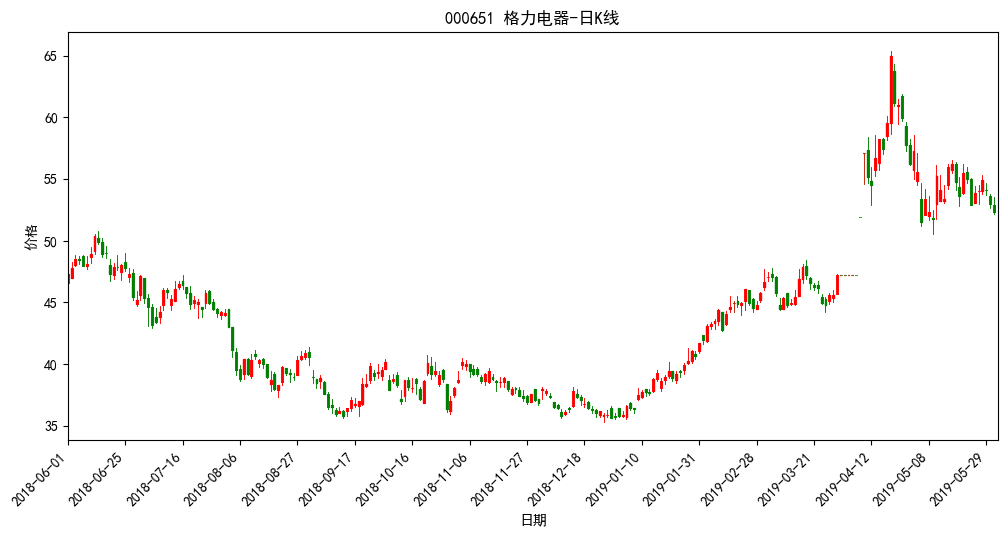

In [10]:
draw_kline_chart(df_stockload)

In [11]:
def draw_volume_chart(stock_dat):
    # 绘制成交量图
    bar_red = np.where(stock_dat.Open < stock_dat.Close,  stock_dat.Volume, 0) # 绘制BAR>0 柱状图
    bar_green = np.where(stock_dat.Open > stock_dat.Close,  stock_dat.Volume, 0) # 绘制BAR<0 柱状图

    layout_dict = {'figsize': (14, 5),
                   'index': stock_dat.index,
                   'draw_kind': {'bar':
                                     {'bar_red': bar_red,
                                      'bar_green': bar_green
                                      }
                                 },
                   'title': u"000651 格力电器-成交量",
                   'ylabel': u"成交量"}

    app.fig_output(**layout_dict)

输出[bar]可视化图表:


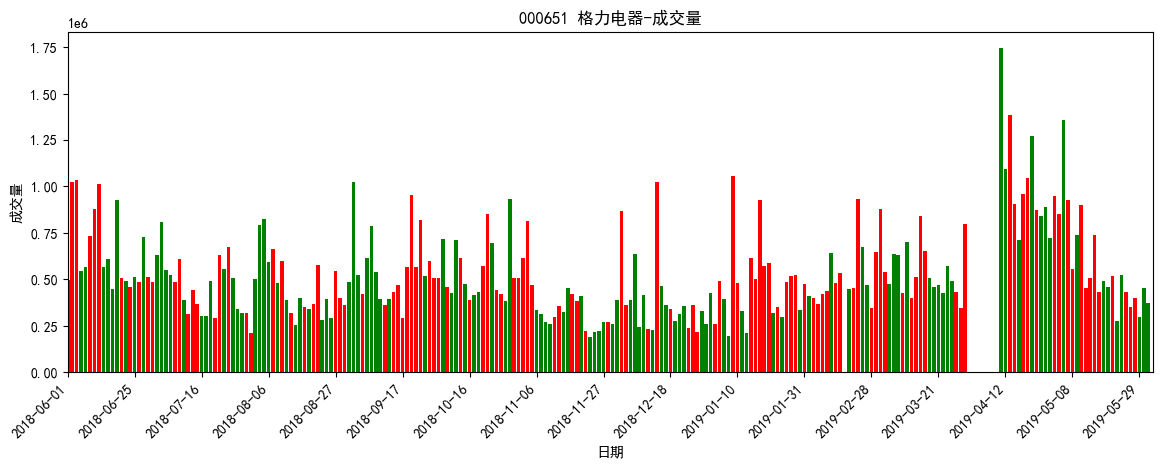

In [12]:
draw_volume_chart(df_stockload)

In [13]:
def draw_sma_chart(stock_dat):
   
    # 绘制移动平均线图

    stock_dat['SMA20'] = stock_dat.Close.rolling(window=20).mean()
    stock_dat['SMA30'] = stock_dat.Close.rolling(window=30).mean()
    stock_dat['SMA60'] = stock_dat.Close.rolling(window=60).mean()
    '''
    fig = plt.figure(figsize=(14, 5), dpi=100, facecolor="white") # 创建fig对象
    graph_sma = fig.add_subplot(1,1,1) # 创建子图
    graph_sma.plot(np.arange(0, len(stock_dat.index)), stock_dat['SMA20'],'black', label='SMA20',lw=1.0)
    graph_sma.plot(np.arange(0, len(stock_dat.index)), stock_dat['SMA30'],'green',label='SMA30', lw=1.0)
    graph_sma.plot(np.arange(0, len(stock_dat.index)), stock_dat['SMA60'],'blue',label='SMA60', lw=1.0)
    graph_sma.legend(loc='best')
    graph_sma.set_title(u"000651 格力电器-均线")
    graph_sma.set_ylabel(u"价格")
    graph_sma.set_xlim(0,len(stock_dat.index)) # 设置x轴的范围
    graph_sma.set_xticks(range(0,len(stock_dat.index),15)) # X轴刻度设定 每15天标一个日期
    graph_sma.set_xticklabels([stock_dat.index.strftime('%Y-%m-%d')[index] \
                               for index in graph_sma.get_xticks()]) # 标签设置为日期
    fig.autofmt_xdate(rotation=45) # 避免x轴日期刻度标签的重叠 将每个ticker标签倾斜45度
    plt.show()
  '''
    layout_dict = {'figsize': (14, 5),
                   'index': stock_dat.index,
                   'draw_kind': {'line':
                                     {'SMA20': stock_dat.SMA20,
                                      'SMA30': stock_dat.SMA30,
                                      'SMA60': stock_dat.SMA60
                                      }
                                 },
                   'title': u"000651 格力电器-均线",
                   'ylabel': u"价格",
                   'xlabel': u"日期",
                   'xticks': 15,
                   'legend': u'best',
                   'xticklabels':'%Y-%m-%d'}
    app.fig_output(**layout_dict)

输出[line]可视化图表:


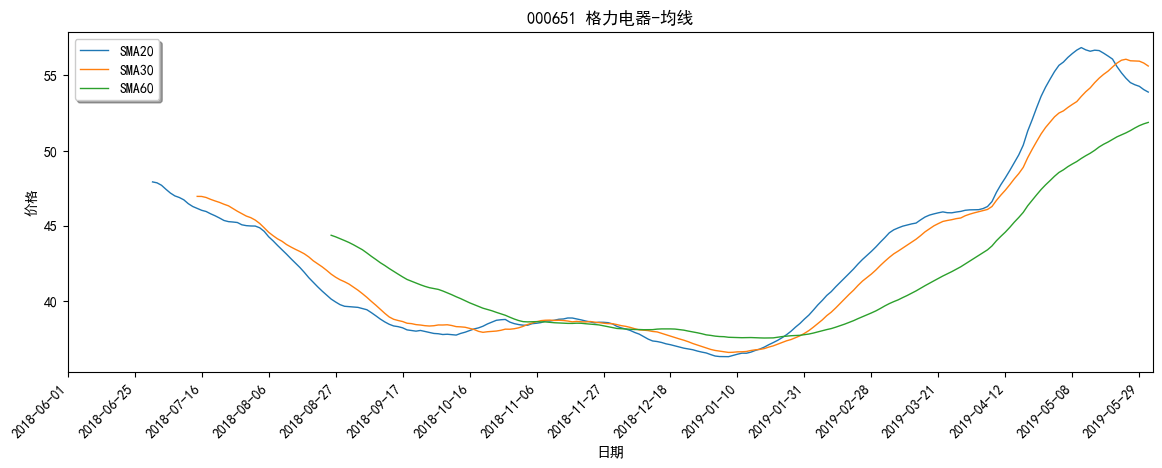

In [14]:
draw_sma_chart(df_stockload)

In [15]:
def draw_kdj_chart(stock_dat):
    # 绘制KDJ图

    low_list = stock_dat['Low'].rolling(9, min_periods=1).min()
    high_list = stock_dat['High'].rolling(9, min_periods=1).max()
    rsv = (stock_dat['Close'] - low_list) / (high_list - low_list) * 100
    stock_dat['K'] = rsv.ewm(com=2, adjust=False).mean()
    stock_dat['D'] = stock_dat['K'].ewm(com=2, adjust=False).mean()
    stock_dat['J'] = 3 * stock_dat['K'] - 2 * stock_dat['D']

    '''
    fig = plt.figure(figsize=(14, 5), dpi=100, facecolor="white")#创建fig对象
    graph_kdj = fig.add_subplot(1,1,1) #创建子图
    graph_kdj.plot(np.arange(0, len(stock_dat.index)), stock_dat['K'], 'blue', label='K')  # K
    graph_kdj.plot(np.arange(0, len(stock_dat.index)), stock_dat['D'], 'g--', label='D')  # D
    graph_kdj.plot(np.arange(0, len(stock_dat.index)), stock_dat['J'], 'r-', label='J')  # J
    graph_kdj.legend(loc='best', shadow=True, fontsize='10')
    graph_kdj.set_ylabel(u"KDJ")
    graph_kdj.set_xlabel("日期")
    graph_kdj.set_xlim(0, len(stock_dat.index))  # 设置x轴的范围
    graph_kdj.set_xticks(range(0, len(stock_dat.index), 15))  # X轴刻度设定 每15天标一个日期
    graph_kdj.set_xticklabels([stock_dat.index.strftime('%Y-%m-%d')[index] \
                               for index in graph_kdj.get_xticks()])  # 标签设置为日期
    fig.autofmt_xdate(rotation=45) # 避免x轴日期刻度标签的重叠 将每个ticker标签倾斜45度

    plt.show()
   '''
    layout_dict = {'figsize': (14, 5),
                   'index': stock_dat.index,
                   'draw_kind': {'line':
                                     {'K': stock_dat.K,
                                      'D': stock_dat.D,
                                      'J': stock_dat.J
                                      }
                                 },
                   'title': u"000651 格力电器-KDJ",
                   'ylabel': u"KDJ",
                   'legend': u'best'}
    app.fig_output(**layout_dict)

输出[line]可视化图表:


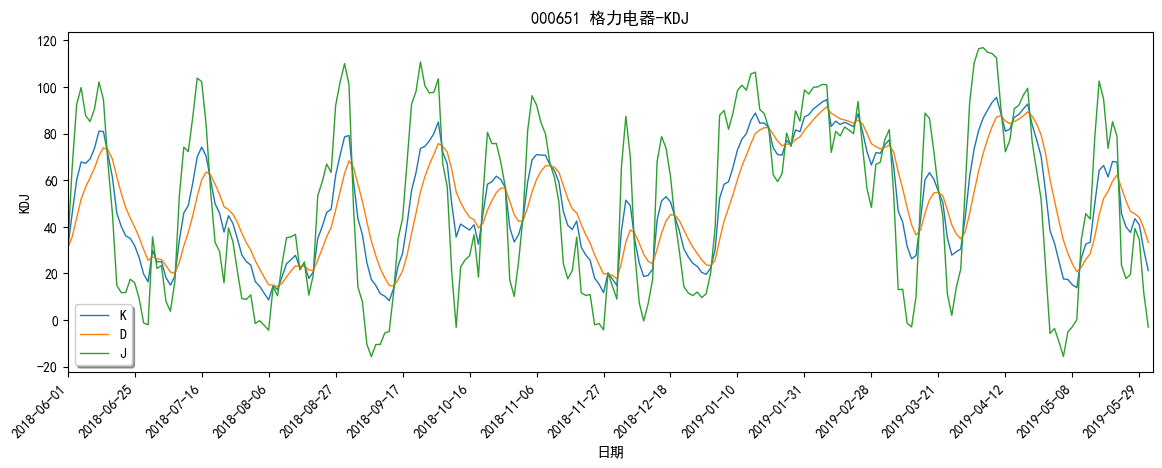

In [16]:
draw_kdj_chart(df_stockload)

In [17]:
def draw_kdj1_chart(stock_dat):
    #绘制KDJ-for in
    xd = 9 - 1
    date = stock_dat.index.to_series()
    RSV = pd.Series(np.zeros(len(date) - xd), index=date.index[xd:])
    Kvalue = pd.Series(0.0, index=RSV.index)
    Dvalue = pd.Series(0.0, index=RSV.index)
    Kvalue[0], Dvalue[0] = 50, 50

    for day_ind in range(xd, len(stock_dat.index)):
        RSV[date[day_ind]] = (stock_dat.Close[day_ind] - stock_dat.Low[day_ind - xd:day_ind + 1].min()) / \
                             (stock_dat.High[day_ind - xd:day_ind + 1].max() - stock_dat.Low[day_ind - xd:day_ind + 1].min()) * 100
        if day_ind > xd:
            index = day_ind - xd
            Kvalue[index] = 2.0 / 3 * Kvalue[index - 1] + RSV[date[day_ind]] / 3
            Dvalue[index] = 2.0 / 3 * Dvalue[index - 1] + Kvalue[index] / 3
        stock_dat['RSV'] = RSV
    stock_dat['K'] = Kvalue
    stock_dat['D'] = Dvalue
    stock_dat['J'] = 3 * Kvalue - 2 * Dvalue

    layout_dict = {'figsize': (14, 5),
                   'index': stock_dat.index,
                   'draw_kind': {'line':
                                     {'K': stock_dat.K,
                                      'D': stock_dat.D,
                                      'J': stock_dat.J
                                      }
                                 },
                   'title': u"000651 格力电器-KDJ",
                   'ylabel': u"KDJ",
                   'legend': u'best'}
    app.fig_output(**layout_dict)

输出[line]可视化图表:


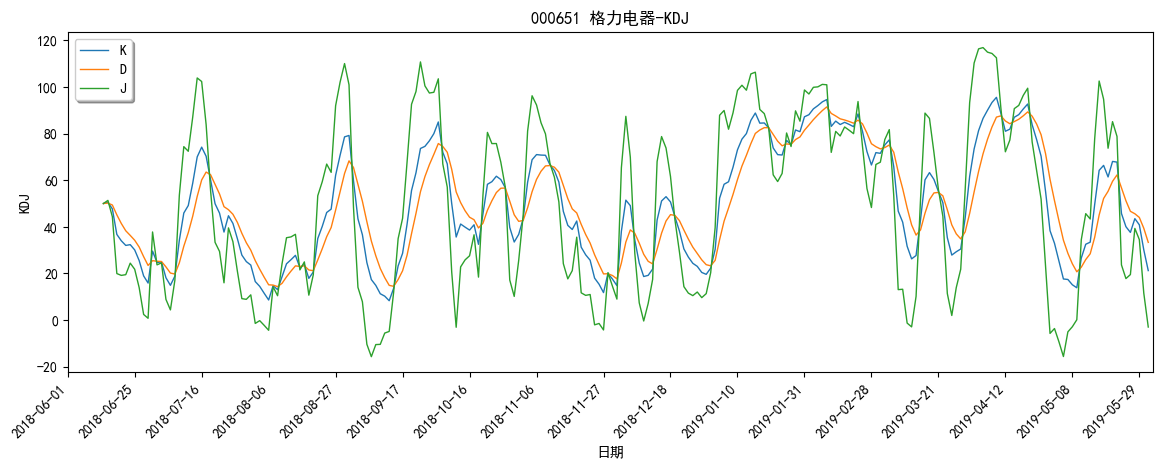

In [18]:
draw_kdj1_chart(df_stockload)

In [19]:
def draw_macd_chart(stock_dat):
    # 绘制MACD

    macd_dif = stock_dat['Close'].ewm(span=12, adjust=False).mean() - stock_dat['Close'].ewm(span=26, adjust=False).mean()
    macd_dea = macd_dif.ewm(span=9, adjust=False).mean()
    macd_bar = 2 * (macd_dif - macd_dea)

    bar_red = np.where(macd_bar > 0,  macd_bar, 0) # 绘制BAR>0 柱状图
    bar_green = np.where(macd_bar < 0,  macd_bar, 0) # 绘制BAR<0 柱状图

    #macd_dif, macd_dea, macd_bar = talib.MACD(stock_dat['Close'].values, fastperiod=12, slowperiod=26, signalperiod=9)
    """
    fig = plt.figure(figsize=(14, 5), dpi=100, facecolor="white") # 创建fig对象
    graph_macd = fig.add_subplot(1,1,1) # 创建子图
    graph_macd.plot(np.arange(0, len(stock_dat.index)), macd_dif, 'red', label='macd dif')  # dif
    graph_macd.plot(np.arange(0, len(stock_dat.index)), macd_dea, 'blue', label='macd dea')  # dea
    graph_macd.bar(np.arange(0, len(stock_dat.index)), bar_red, facecolor='red')
    graph_macd.bar(np.arange(0, len(stock_dat.index)), bar_green, facecolor='green')
    graph_macd.legend(loc='best',shadow=True, fontsize ='10')
    graph_macd.set_ylabel(u"MACD")
    graph_macd.set_xlabel("日期")
    graph_macd.set_xlim(0,len(stock_dat.index)) # 设置x轴的范围
    graph_macd.set_xticks(range(0,len(stock_dat.index),15)) # X轴刻度设定 每15天标一个日期
    graph_macd.set_xticklabels([stock_dat.index.strftime('%Y-%m-%d')[index] for index in graph_macd.get_xticks()])  # 标签设置为日期
    fig.autofmt_xdate(rotation=45) # 避免x轴日期刻度标签的重叠 将每个ticker标签倾斜45度
    plt.show()
    """
    layout_dict = {'figsize': (14, 5),
                   'index': stock_dat.index,
                   'draw_kind': {'bar':
                                     {'bar_red': bar_red,
                                      'bar_green': bar_green
                                      },
                                 'line':
                                     {'macd dif': macd_dif,
                                      'macd dea': macd_dea
                                      }
                                 },
                   'title': u"000651 格力电器-MACD",
                   'ylabel': u"MACD",
                   'legend': u'best'}

    app.fig_output(**layout_dict)

输出[bar]可视化图表:
输出[line]可视化图表:


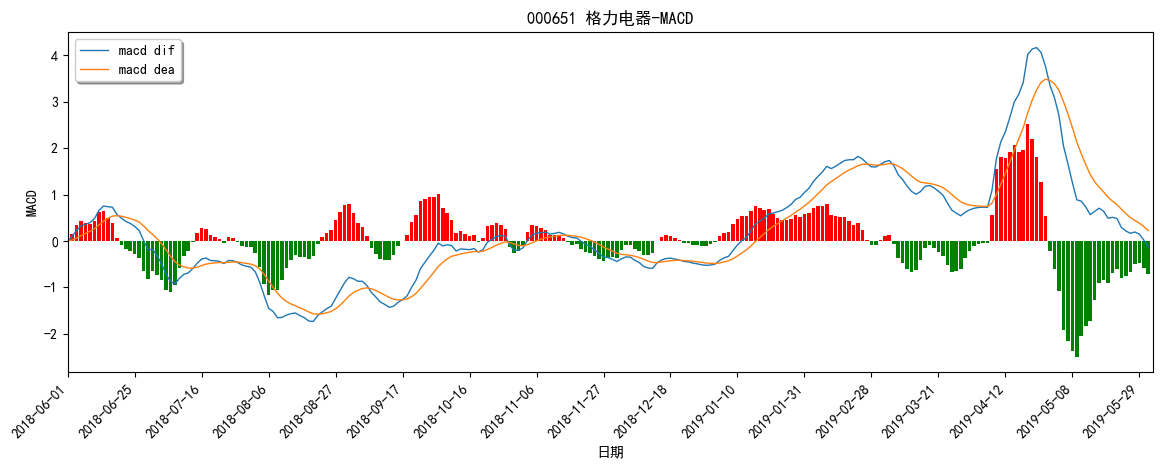

In [20]:
draw_macd_chart(df_stockload)

In [21]:
def draw_cross_annotate(stock_dat):
    # 绘制均线金叉和死叉

    #graph_sma.legend(loc='upper left')
    #graph_range = stock_dat.High.max() - stock_dat.Low.min()
    #graph_sma.set_ylim(stock_dat.Low.min() - graph_range * 0.25, stock_dat.High.max()) # 设置y轴的范围

    # 绘制移动平均线图
    stock_dat['Ma20'] = stock_dat.Close.rolling(window=20).mean()  # pd.rolling_mean(stock_dat.Close,window=20)
    stock_dat['Ma30'] = stock_dat.Close.rolling(window=30).mean()  # pd.rolling_mean(stock_dat.Close,window=30)

    # 长短期均线序列相减取符号
    list_diff = np.sign(stock_dat['Ma20'] - stock_dat['Ma30'])
    # print(list_diff)
    list_signal = np.sign(list_diff - list_diff.shift(1))
    # print(list_signal)

    down_cross = stock_dat[list_signal < 0]
    up_cross = stock_dat[list_signal > 0]

    # 循环遍历 显示均线金叉/死叉提示符
    layout_dict = {'figsize': (14, 5),
                   'index': stock_dat.index,
                   'draw_kind': {'line':
                                     {'SMA-20': stock_dat.Ma20,
                                      'SMA-30': stock_dat.Ma30
                                      },
                                 'annotate':
                                     {u'死叉':
                                          {'andata': down_cross,
                                           'va':'top',
                                           'xy_y': 'Ma20',
                                           'xytext':(-30,-stock_dat['Ma20'].mean()*0.5),
                                           'fontsize': 8,
                                           'arrow': dict(facecolor='green', shrink=0.1)
                                          },
                                      u'金叉':
                                          {'andata': up_cross,
                                           'va': 'bottom',
                                           'xy_y': 'Ma20',
                                           'xytext': (-30, stock_dat['Ma20'].mean() * 0.5),
                                           'fontsize': 8,
                                           'arrow': dict(facecolor='red', shrink=0.1)
                                           }
                                      }
                                 },
                   'title': u"000651 格力电器-均线交叉",
                   'ylabel': u"价格",
                   'xlabel': u"日期",
                   'legend': u'best'}
    app.fig_output(**layout_dict)

输出[line]可视化图表:
输出[annotate]可视化图表:


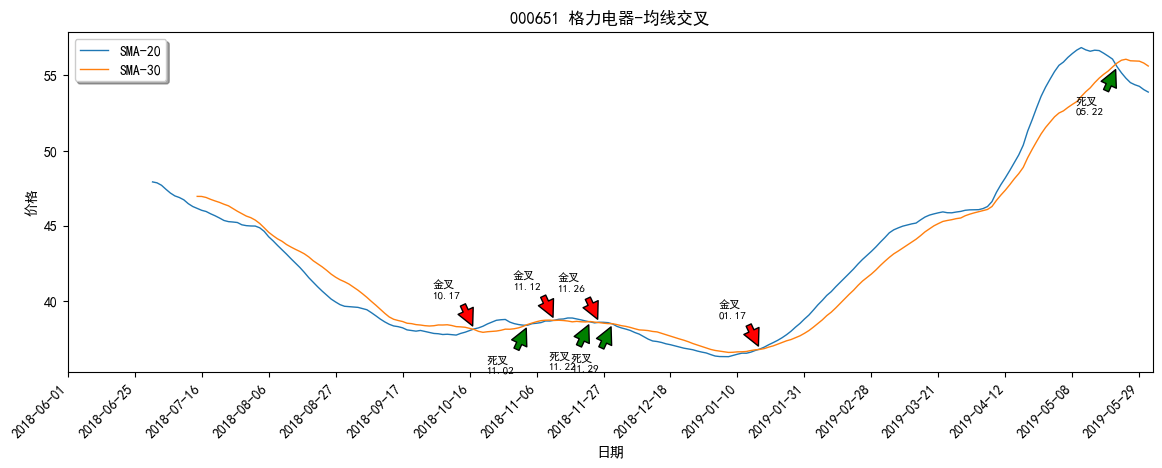

In [22]:
draw_cross_annotate(df_stockload)

In [23]:
def apply_gap(changeRatio, preLow, preHigh, Low, High, threshold):
    jump_power = 0
    if (changeRatio > 0) and ((Low - preHigh) > threshold):
        # 向上跳空 (今最低-昨最高)/阈值
        jump_power = (Low - preHigh) / threshold # 正数
    elif (changeRatio < 0) and ((preLow - High) > threshold):
        # 向下跳空 (今最高-昨最低)/阈值
        jump_power = (High - preLow) / threshold # 负数
    return jump_power

In [24]:
def draw_gap_annotate(stock_dat):
    # 绘制K线图
    # 挖掘跳空缺口
    jump_threshold = stock_dat.Close.median()*0.01 # 跳空阈值 收盘价中位数*0.01
    stock_dat['changeRatio'] = stock_dat.Close.pct_change() * 100  # 计算涨/跌幅 (今收-昨收)/昨收*100% 判断向上跳空缺口/向下跳空缺口
    stock_dat['preLow'] = stock_dat.Low.shift(1)  # 增加昨日最低价序列
    stock_dat['preHigh'] = stock_dat.High.shift(1) # 增加昨日最高价序列
    stock_dat = stock_dat.assign(jump_power = 0)

    #for kl_index in np.arange(0, df_stockload.shape[0]):
    #    today = df_stockload.iloc[kl_index]
    #note: A value is trying to be set on a copy of a slice from a DataFrame
    #involve change the value of df_stockload but iloc just copy the dataframe

    stock_dat['jump_power'] = stock_dat.apply(lambda row:apply_gap(row['changeRatio'],
                                                     row['preLow'],
                                                     row['preHigh'],
                                                     row['Low'],
                                                     row['High'],
                                                     jump_threshold),
                                                     axis = 1)
    up_jump = stock_dat[(stock_dat.changeRatio > 0) & (stock_dat.jump_power > 0)]
    down_jump = stock_dat[(stock_dat.changeRatio < 0) & (stock_dat.jump_power < 0)]

    layout_dict = {'figsize': (14, 7),
                   'index': stock_dat.index,
                   'draw_kind': {'ochl':# 绘制K线图
                                     {'Open': stock_dat.Open,
                                      'Close': stock_dat.Close,
                                      'High': stock_dat.High,
                                      'Low': stock_dat.Low
                                      },
                                 'annotate':
                                     {u'up':
                                          {'andata': up_jump,
                                           'va': 'top',
                                           'xy_y': 'preHigh',
                                           'xytext': (0,-stock_dat['Close'].mean() * 0.5),
                                           'fontsize':  8,
                                           'arrow': dict(facecolor='red', shrink=0.1)
                                           },
                                      u'down':
                                          {'andata': down_jump,
                                           'va': 'bottom',
                                           'xy_y': 'preLow',
                                           'xytext': (0,stock_dat['Close'].mean() * 0.5),
                                           'fontsize':  8,
                                           'arrow': dict(facecolor='green', shrink=0.1)
                                           }
                                      }
                                 },
                   'title': u"000651 格力电器-跳空缺口",
                   'ylabel': u"价格"}
    app.fig_output(**layout_dict)

    print(up_jump.filter(['jump_power', 'preClose', 'changeRatio', 'Close', 'Volume'])) # 向上跳空缺口 按顺序显示列
    """
                jump_power  changeRatio  Close    Volume
    Date                                                
    2018-10-22        1.07         3.83  40.11  8.51e+07
    2019-01-09        1.58         3.22  37.51  1.06e+08
    2019-04-09       11.48        10.00  51.93  1.08e+07
    2019-04-10        6.40         9.99  57.12  3.23e+08
    """
    print(down_jump.filter(['jump_power', 'preClose', 'changeRatio', 'Close', 'Volume'])) # 向下跳空缺口 按顺序显示列
    """
                jump_power  changeRatio  Close    Volume
    Date                                                
    2018-10-08       -1.22        -5.65  37.93  7.15e+07
    """

    format = lambda x: '%.2f' % x
    up_jump = up_jump[(np.abs(up_jump.changeRatio) > 2) & (up_jump.Volume > up_jump.Volume.median())]  # abs取绝对值
    up_jump = up_jump.applymap(format)  # 处理后数据为str
    print(up_jump.filter(['jump_power', 'preClose', 'changeRatio', 'Close', 'Volume'])) # 按顺序只显示该列
    """
               jump_power changeRatio  Close        Volume
    Date                                                  
    2019-01-09       1.58        3.22  37.51  105806077.00
    2019-04-10       6.40        9.99  57.12  322875034.00
    """
    down_jump = down_jump[(np.abs(down_jump.changeRatio) > 2) & (down_jump.Volume > down_jump.Volume.median())]  # abs取绝对值
    down_jump = down_jump.applymap(format)  # 处理后数据为str
    print(down_jump.filter(['jump_power', 'preClose', 'changeRatio', 'Close', 'Volume'])) # 按顺序只显示该列
    """
    Empty DataFrame
    Columns: [jump_power, changeRatio, Close, Volume]
    Index: []
    """

输出[ochl]可视化图表:
输出[annotate]可视化图表:


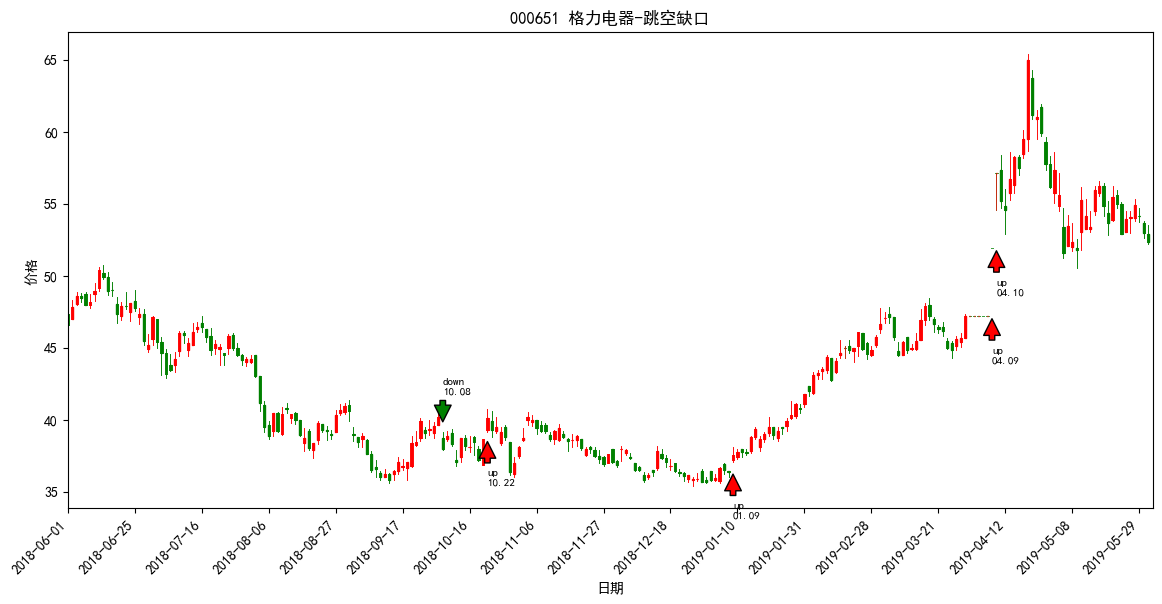

            jump_power  changeRatio  Close      Volume
date                                                  
2018-10-22    1.070039     3.831219  40.11   850762.66
2019-01-09    1.580739     3.219593  37.51  1058060.77
2019-04-09   11.478599     9.997882  51.93   108436.42
2019-04-10    6.395914     9.994223  57.12  3228750.40
            jump_power  changeRatio  Close     Volume
date                                                 
2018-10-08   -1.215953    -5.646766  37.93  715413.96
           jump_power changeRatio  Close      Volume
date                                                
2019-01-09       1.58        3.22  37.51  1058060.77
2019-04-10       6.40        9.99  57.12  3228750.40
Empty DataFrame
Columns: [jump_power, changeRatio, Close, Volume]
Index: []


In [25]:
draw_gap_annotate(df_stockload)

In [26]:
def draw_kweek_chart(stock_dat):
    #周期重采样
    #rule='W'周 how=last()最后一天 closed='right'右闭合 label='right'右标签
    #print(stock_dat.resample('W', closed='right', label='right').last().head())

    Freq_T = 'W-FRI'
    #print(stock_dat.resample(Freq_T, closed='right', label='right').last().head())

    #周线Close等于一周中最后一个交易日Close
    week_dat = stock_dat.resample(Freq_T, closed='right', label='right').last()
    #周线Open等于一周中第一个交易日Open
    week_dat.Open = stock_dat.Open.resample(Freq_T, closed='right', label='right').first()
    #周线High等于一周中High的最大值
    week_dat.High = stock_dat.High.resample(Freq_T, closed='right', label='right').max()
    #周线Low等于一周中Low的最小值
    week_dat.Low = stock_dat.Low.resample(Freq_T, closed='right', label='right').min()
    #周线Volume等于一周中Volume的总和
    week_dat.Volume = stock_dat.Volume.resample(Freq_T, closed='right', label='right').sum()
    #print(week_dat.head())

    layout_dict = {'figsize': (14, 7),
                   'index': week_dat.index,
                   'draw_kind': {'ochl':
                                     {'Open': week_dat.Open,
                                      'Close': week_dat.Close,
                                      'High': week_dat.High,
                                      'Low': week_dat.Low
                                      }
                                 },
                   'title': u"000651 格力电器-周K线",
                   'ylabel': u"价格"}
    app.fig_output(**layout_dict)

输出[ochl]可视化图表:


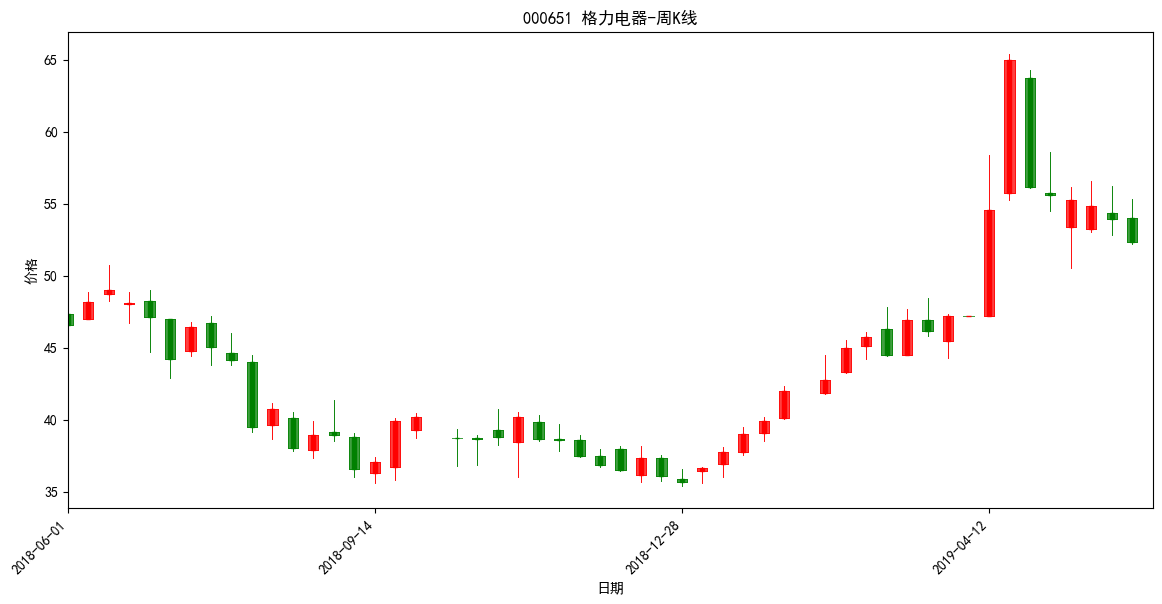

In [27]:
draw_kweek_chart(df_stockload)

In [28]:
def draw_fibonacci_chart(stock_dat):
    # 黄金分割线
    Fib_max = stock_dat.Close.max()
    Fib_maxid = stock_dat.index.get_loc(stock_dat.Close.idxmax())
    Fib_min = stock_dat.Close.min()
    Fib_minid = stock_dat.index.get_loc(stock_dat.Close.idxmin())
    Fib_382 = (Fib_max - Fib_min) * 0.382 + Fib_min
    Fib_618 = (Fib_max - Fib_min) * 0.618 + Fib_min
    print(u'黄金分割0.382：{}'.format(round(Fib_382, 2)))
    print(u'黄金分割0.618：{}'.format(round(Fib_618, 2)))
    # 黄金分割0.382：46.88
    # 黄金分割0.618：53.8

    max_df = stock_dat[stock_dat.Close == stock_dat.Close.max()]
    min_df = stock_dat[stock_dat.Close == stock_dat.Close.min()]
    print(max_df)
    print(min_df)

    #graph_kline.legend(['0.382', '0.618'], loc='upper left')

    # 绘制K线图+支撑/阻力
    layout_dict = {'figsize': (14, 7),
                   'index': stock_dat.index,
                   'draw_kind': {'ochl':# 绘制K线图
                                     {'Open': stock_dat.Open,
                                      'Close': stock_dat.Close,
                                      'High': stock_dat.High,
                                      'Low': stock_dat.Low
                                      },
                                'hline':
                                    {'Fib_382':
                                         {'pos': Fib_382,
                                          'c': 'r'
                                         },
                                     'Fib_618':
                                         {'pos': Fib_618,
                                          'c': 'g'
                                         }
                                     },
                                 'annotate':
                                     {u'max':
                                          {'andata': max_df,
                                           'va': 'top',
                                           'xy_y': 'High',
                                           'xytext': (-30,stock_dat.Close.mean()),
                                           'fontsize':  8,
                                           'arrow': dict(facecolor='red', shrink=0.1)
                                           },
                                      u'min':
                                          {'andata': min_df,
                                           'va': 'bottom',
                                           'xy_y': 'Low',
                                           'xytext': (-30,-stock_dat.Close.mean()),
                                           'fontsize':  8,
                                           'arrow': dict(facecolor='green', shrink=0.1)
                                           }
                                      }
                                 },
                   'title': u"000651 格力电器-支撑/阻力位",
                   'ylabel': u"价格",
                   'legend': u'best'}
    app.fig_output(**layout_dict)

黄金分割0.382：46.88
黄金分割0.618：53.8
            Open  Close  High    Low      Volume   SMA20   SMA30      SMA60  \
date                                                                          
2019-04-19  59.5   65.0  65.4  58.68  1044285.16  51.307  49.538  46.347167   

                    K          D          J        RSV    Ma20    Ma30  \
date                                                                     
2019-04-19  92.707543  89.319439  99.483751  97.030438  51.307  49.538   

            changeRatio  preLow  preHigh  
date                                      
2019-04-19     9.243697   58.16     60.1  
             Open  Close   High    Low     Volume    SMA20      SMA30  \
date                                                                    
2018-12-27  36.45  35.68  36.58  35.66  327593.84  36.6355  37.011333   

                SMA60          K          D         J        RSV     Ma20  \
date                                                                        
2018-

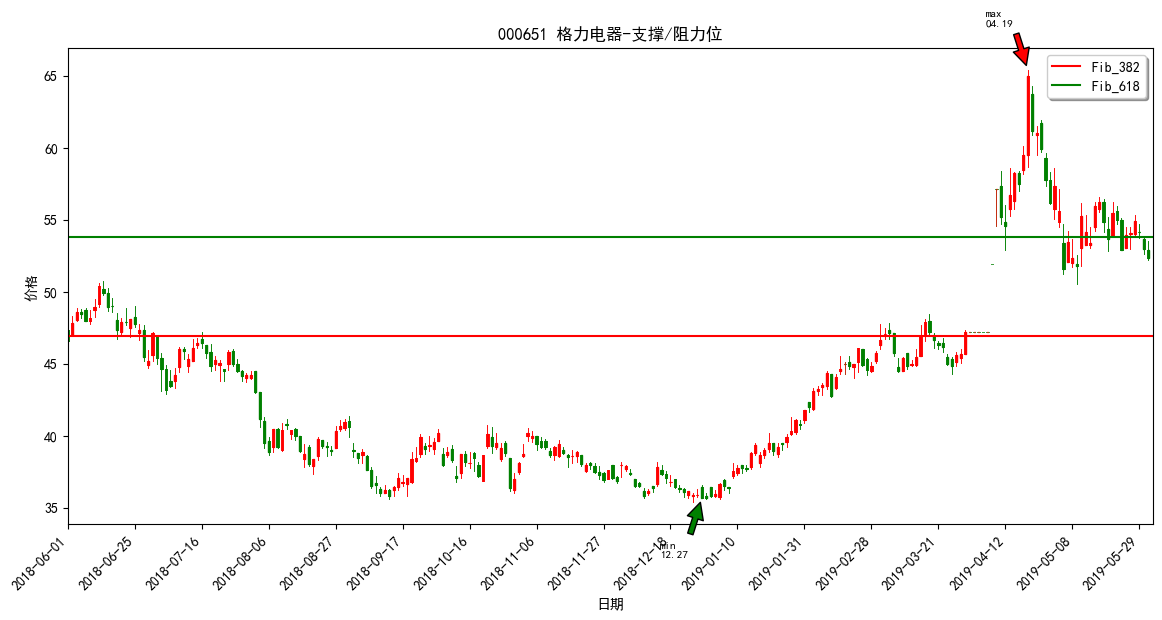

In [29]:
draw_fibonacci_chart(df_stockload)

## 使用Ta-Lib库计算技术指标

In [30]:
def draw_tasma_chart(stock_dat):
    # 绘制talib SMA

    stock_dat['SMA20'] = talib.SMA(stock_dat.Close, timeperiod=20)
    stock_dat['SMA30'] = talib.SMA(stock_dat.Close, timeperiod=30)
    stock_dat['SMA60'] = talib.SMA(stock_dat.Close, timeperiod=60)
    stock_dat['SMA20'].fillna(method='bfill',inplace=True)
    stock_dat['SMA30'].fillna(method='bfill',inplace=True)
    stock_dat['SMA60'].fillna(method='bfill',inplace=True)

    #stock_dat['Ma20'] = talib.MA(stock_dat.Close, timeperiod=20, matype=0)
    #stock_dat['Ma30'] = talib.MA(stock_dat.Close, timeperiod=30, matype=1)
    #stock_dat['Ma60'] = talib.MA(stock_dat.Close, timeperiod=60, matype=2)

    """
    fig = plt.figure(figsize=(14, 5), dpi=100, facecolor="white")#创建fig对象
    graph_sma = fig.add_subplot(1,1,1) #创建子图
    graph_sma.plot(np.arange(0, len(stock_dat.index)), stock_dat['Ma20'],'black', label='M20',lw=1.0)
    graph_sma.plot(np.arange(0, len(stock_dat.index)), stock_dat['Ma30'],'green',label='M30', lw=1.0)
    graph_sma.plot(np.arange(0, len(stock_dat.index)), stock_dat['Ma60'],'blue',label='M60', lw=1.0)
    graph_sma.legend(loc='best')
    graph_sma.set_title(u"000651 格力电器-MA-talib")
    graph_sma.set_ylabel(u"价格")
    graph_sma.set_xlim(0,len(stock_dat.index)) #设置x轴的范围
    graph_sma.set_xticks(range(0,len(stock_dat.index),15))#X轴刻度设定 每15天标一个日期
    graph_sma.set_xticklabels([stock_dat.index.strftime('%Y-%m-%d')[index] for index in graph_sma.get_xticks()])#标签设置为日期
    fig.autofmt_xdate(rotation=45) #避免x轴日期刻度标签的重叠 将每个ticker标签倾斜45度
    plt.show()
    """
    layout_dict = {'figsize': (14, 5),
                   'index': stock_dat.index,
                   'draw_kind': {'line':
                                     {'SMA20': stock_dat.SMA20,
                                      'SMA30': stock_dat.SMA30,
                                      'SMA60': stock_dat.SMA60
                                      }
                                 },
                   'title': u"000651 格力电器-SMA-talib",
                   'ylabel': u"价格",
                   'legend': u'best'}
    app.fig_output(**layout_dict)

输出[line]可视化图表:


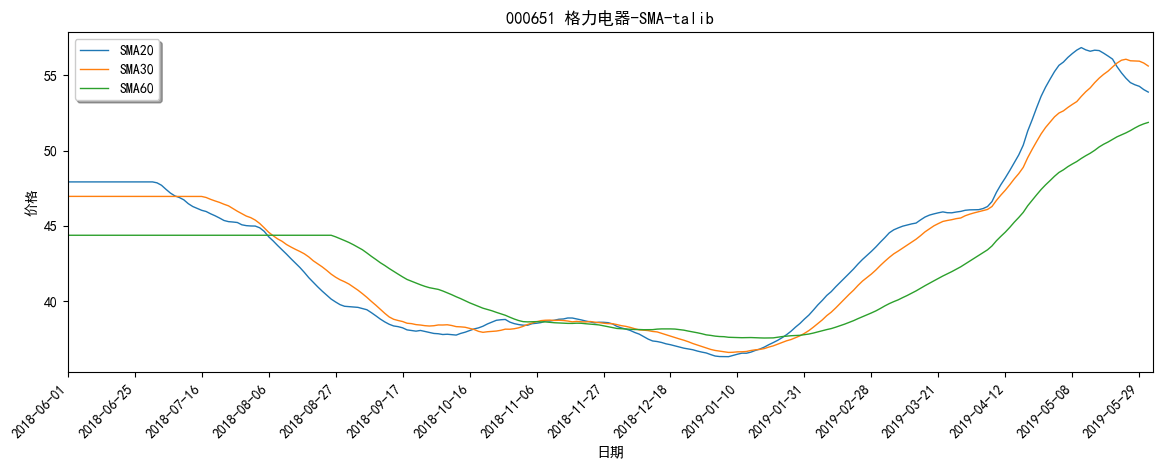

In [31]:
draw_tasma_chart(df_stockload)

In [32]:
def draw_tamacd_chart(stock_dat):
    # 绘制talib MACD

    macd_dif, macd_dea, macd_bar = talib.MACD(stock_dat['Close'].values, fastperiod=12, slowperiod=26, signalperiod=9)

    #RuntimeWarning: invalid value encountered in greater
    #RuntimeWarning: invalid value encountered in less
    #solve the problem
    macd_dif[np.isnan(macd_dif)] ,macd_dea[np.isnan(macd_dea)], macd_bar[np.isnan(macd_bar)]= 0, 0, 0
    bar_red = np.where(macd_bar > 0,  2 * macd_bar, 0)# 绘制BAR>0 柱状图
    bar_green = np.where(macd_bar < 0,  2 * macd_bar, 0)# 绘制BAR<0 柱状图
    """
    fig = plt.figure(figsize=(14, 5), dpi=100, facecolor="white")#创建fig对象
    graph_macd = fig.add_subplot(1,1,1) #创建子图
    graph_macd.plot(np.arange(0, len(stock_dat.index)), macd_dif, 'red', label='macd dif')  # dif
    graph_macd.plot(np.arange(0, len(stock_dat.index)), macd_dea, 'blue', label='macd dea')  # dea
    graph_macd.bar(np.arange(0, len(stock_dat.index)), bar_red, facecolor='red')
    graph_macd.bar(np.arange(0, len(stock_dat.index)), bar_green, facecolor='green')
    graph_macd.legend(loc='best',shadow=True, fontsize ='10')
    graph_macd.set_ylabel(u"MACD-talib")
    graph_macd.set_xlabel("日期")
    graph_macd.set_xlim(0,len(stock_dat.index)) #设置x轴的范围
    graph_macd.set_xticks(range(0,len(stock_dat.index),15))#X轴刻度设定 每15天标一个日期
    graph_macd.set_xticklabels([stock_dat.index.strftime('%Y-%m-%d')[index] for index in graph_macd.get_xticks()])  # 标签设置为日期
    fig.autofmt_xdate(rotation=45) #避免x轴日期刻度标签的重叠 将每个ticker标签倾斜45度
    plt.show()
    """
    layout_dict = {'figsize': (14, 5),
                   'index': stock_dat.index,
                   'draw_kind': {'bar':
                                     {'bar_red': bar_red,
                                      'bar_green': bar_green
                                      },
                                 'line':
                                     {'macd dif': macd_dif,
                                      'macd dea': macd_dea
                                      }
                                 },
                   'title': u"000651 格力电器-MACD-talib",
                   'ylabel': u"MACD",
                   'legend': u'best'}
    app.fig_output(**layout_dict)

输出[bar]可视化图表:
输出[line]可视化图表:


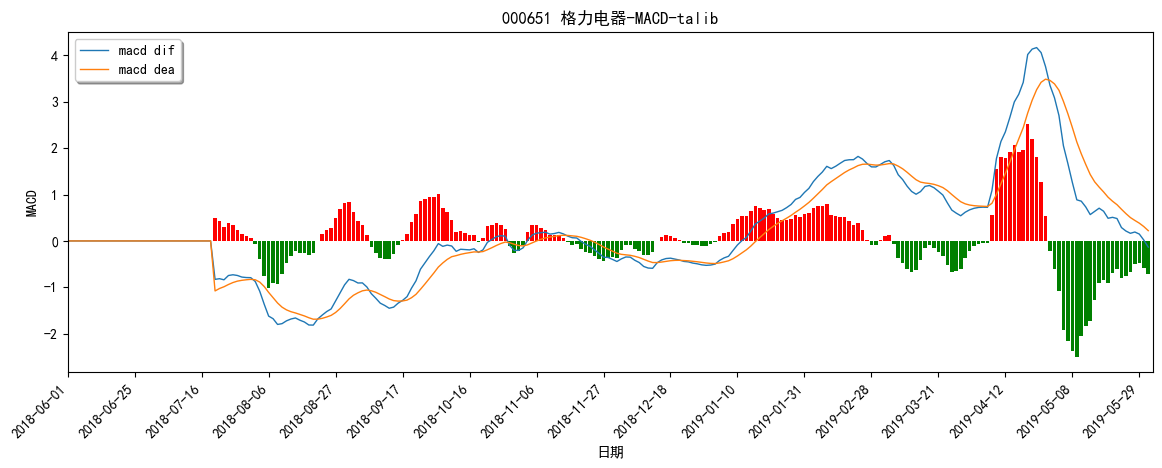

In [33]:
draw_tamacd_chart(df_stockload)

In [34]:
def draw_takdj_chart(stock_dat):
    # 绘制talib KDJ

    stock_dat['K'], stock_dat['D'] = talib.STOCH(stock_dat.High.values, stock_dat.Low.values, stock_dat.Close.values,\
                                           fastk_period=9, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    stock_dat['K'].fillna(0,inplace=True), stock_dat['D'].fillna(0,inplace=True)
    stock_dat['J'] = 3 * stock_dat['K'] - 2 * stock_dat['D']
    """
    fig = plt.figure(figsize=(14, 5), dpi=100, facecolor="white") # 创建fig对象
    graph_kdj = fig.add_subplot(1,1,1) # 创建子图
    graph_kdj.plot(np.arange(0, len(stock_dat.index)), stock_dat['K'], 'blue', label='K')  # K
    graph_kdj.plot(np.arange(0, len(stock_dat.index)), stock_dat['D'], 'g--', label='D')  # D
    graph_kdj.plot(np.arange(0, len(stock_dat.index)), stock_dat['J'], 'r-', label='J')  # J
    graph_kdj.legend(loc='best', shadow=True, fontsize='10')
    graph_kdj.set_ylabel(u"KDJ-talib")
    graph_kdj.set_xlabel("日期")
    graph_kdj.set_xlim(0, len(stock_dat.index))  # 设置x轴的范围
    graph_kdj.set_xticks(range(0, len(stock_dat.index), 15))  # X轴刻度设定 每15天标一个日期
    graph_kdj.set_xticklabels([stock_dat.index.strftime('%Y-%m-%d')[index] for index in graph_kdj.get_xticks()])  # 标签设置为日期
    fig.autofmt_xdate(rotation=45) # 避免x轴日期刻度标签的重叠 将每个ticker标签倾斜45度
    plt.show()
    """
    layout_dict = {'figsize': (14, 5),
                   'index': stock_dat.index,
                   'draw_kind': {'line':
                                     {'K': stock_dat.K,
                                      'D': stock_dat.D,
                                      'J': stock_dat.J
                                      }
                                 },
                   'title': u"000651 格力电器-KDJ-talib",
                   'ylabel': u"KDJ",
                   'legend': u'best'}
    app.fig_output(**layout_dict)

输出[line]可视化图表:


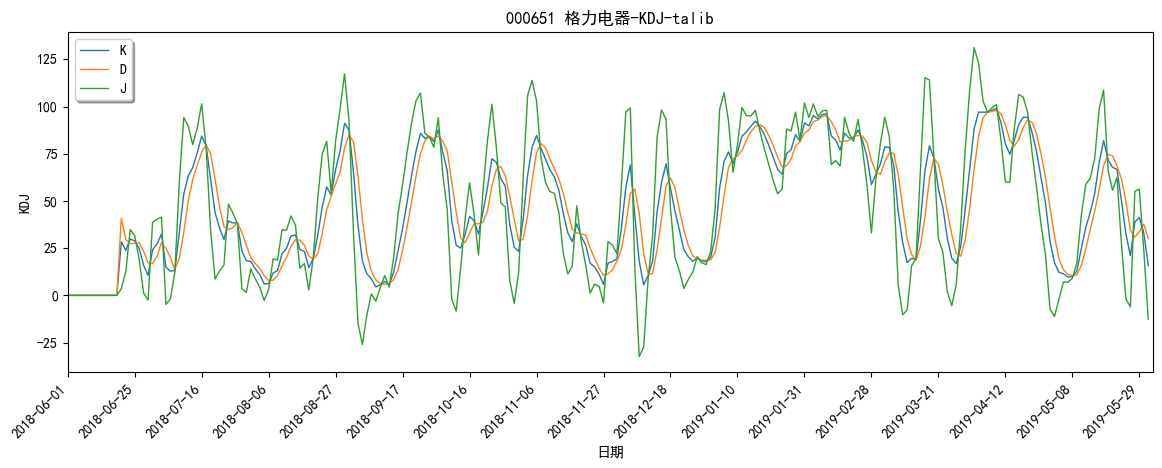

In [35]:
draw_takdj_chart(df_stockload)

In [36]:
def draw_takpattern_annotate(stock_dat):
    # 绘制 talib K线形态 乌云压顶
    #CDL2CROWS = talib.CDL2CROWS(stock_dat.Open.values, stock_dat.High.values, stock_dat.Low.values,stock_dat.Close.values)
    #CDLHAMMER = talib.CDLHAMMER(stock_dat.Open.values, stock_dat.High.values, stock_dat.Low.values,stock_dat.Close.values)
    #CDLMORNINGSTAR = talib.CDLMORNINGSTAR(stock_dat.Open.values, stock_dat.High.values, stock_dat.Low.values,stock_dat.Close.values)
    CDLDARKCLOUDCOVER = talib.CDLDARKCLOUDCOVER(stock_dat.Open.values, stock_dat.High.values, stock_dat.Low.values,stock_dat.Close.values)

    # 绘制K线图
    pattern = stock_dat[(CDLDARKCLOUDCOVER == 100)|(CDLDARKCLOUDCOVER == -100)]

    layout_dict = {'figsize': (14, 7),
                   'index': stock_dat.index,
                   'draw_kind': {'ochl':# 绘制K线图
                                     {'Open': stock_dat.Open,
                                      'Close': stock_dat.Close,
                                      'High': stock_dat.High,
                                      'Low': stock_dat.Low
                                      },
                                 'annotate':
                                     {u'CDLDARKCLOUDCOVER':
                                          {'andata': pattern,
                                           'va': 'bottom',
                                           'xy_y': 'High',
                                           'xytext': (0,stock_dat['Close'].mean()),
                                           'fontsize': 8,
                                           'arrow': dict(arrowstyle='->',facecolor='blue', connectionstyle="arc3,rad=.2")
                                           }
                                      }
                                 },
                   'title': u"000651 格力电器-日K线-CDLDARKCLOUDCOVER",
                   'ylabel': u"价格"}
    app.fig_output(**layout_dict)

输出[ochl]可视化图表:
输出[annotate]可视化图表:


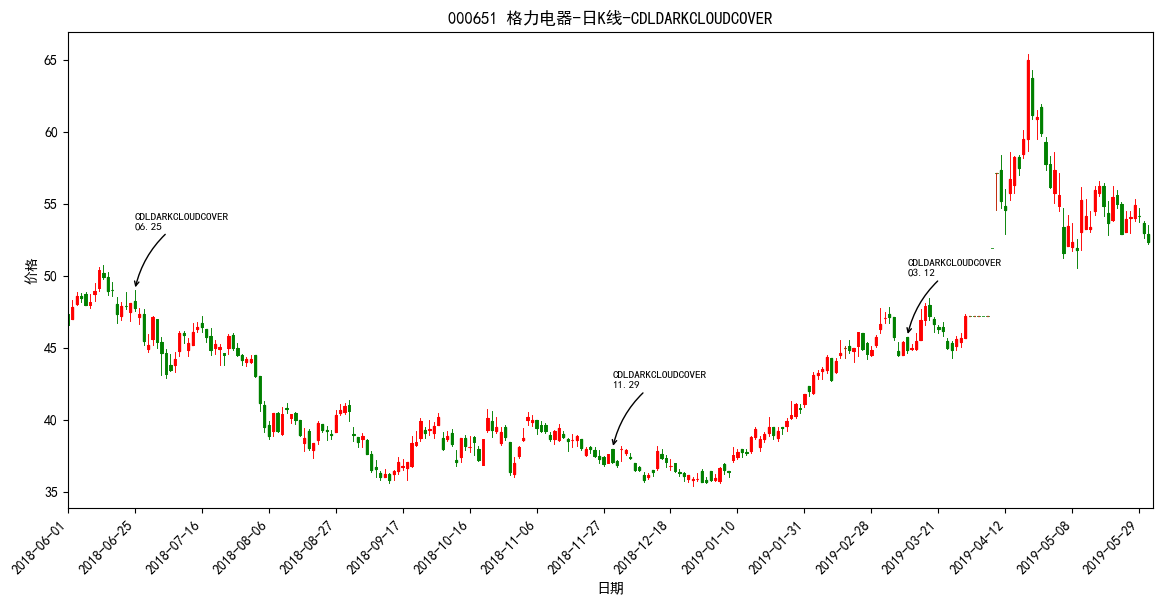

In [37]:
draw_takpattern_annotate(df_stockload)

In [38]:
def talib_speed_example():
    # 对比效率上的差别
    close_price = np.random.random(1000000)
    df_random = pd.DataFrame(close_price, columns=['close_price'])

    start_a = time.perf_counter()
    talib.SMA(close_price, timeperiod=20)
    end_a = time.perf_counter()
    print("Time talib：", end_a-start_a) # talib time consuming

    start_p = time.perf_counter()
    df_random.rolling(20).mean()
    end_p = time.perf_counter()
    print("Time pandas：", end_p-start_p) # Pandas time consuming

In [39]:
talib_speed_example()

Time talib： 0.008621499997389037
Time pandas： 0.0554924000025494


In [40]:
class MultiGraphIf(MplTypesDraw):

    app = DefTypesPool()
    ##########################行情分析界面###############################
    @app.route_types(u"ochl")
    def ochl_graph(stock_dat, sub_graph, df_dat=None):  # prepare data
        type_dict = {'Open': stock_dat.Open,
                     'Close': stock_dat.Close,
                     'High': stock_dat.High,
                     'Low': stock_dat.Low
                     }
        view_function = MplTypesDraw.mpl.route_output(u"ochl")
        view_function(stock_dat.index, type_dict, sub_graph)

    @app.route_types(u"sma")
    def sma_graph(stock_dat, sub_graph, periods):  # prepare data
        for val in periods:
            type_dict = {'SMA'+str(val): stock_dat.Close.rolling(window=val).mean()}
            view_function = MplTypesDraw.mpl.route_output(u"line")
            view_function(stock_dat.index, type_dict, sub_graph)

    @app.route_types(u"vol")
    def vol_graph(stock_dat, sub_graph, df_dat=None):  # prepare data
        type_dict = {'bar_red': np.where(stock_dat.Open < stock_dat.Close, stock_dat.Volume, 0), # 绘制BAR>0 柱状图
                     'bar_green': np.where(stock_dat.Open > stock_dat.Close, stock_dat.Volume, 0) # 绘制BAR<0 柱状图
                     }
        view_function = MplTypesDraw.mpl.route_output(u"bar")
        view_function(stock_dat.index, type_dict, sub_graph)


    @app.route_types(u"macd")
    def macd_graph(stock_dat, sub_graph, df_dat=None):  # prepare data

        macd_dif = stock_dat['Close'].ewm(span=12, adjust=False).mean() - stock_dat['Close'].ewm(span=26,                                                                                         adjust=False).mean()
        macd_dea = macd_dif.ewm(span=9, adjust=False).mean()
        macd_bar = 2 * (macd_dif - macd_dea)

        type_dict = {'bar_red': np.where(macd_bar > 0, macd_bar, 0),  # 绘制BAR>0 柱状图
                     'bar_green': np.where(macd_bar < 0, macd_bar, 0)  # 绘制BAR<0 柱状图
                     }
        view_function = MplTypesDraw.mpl.route_output(u"bar")
        view_function(stock_dat.index, type_dict, sub_graph)

        type_dict = {'macd dif': macd_dif,
                     'macd dea': macd_dea
                     }
        view_function = MplTypesDraw.mpl.route_output(u"line")
        view_function(stock_dat.index, type_dict, sub_graph)

    @app.route_types(u"kdj")
    def kdj_graph(stock_dat, sub_graph, df_dat=None):  # prepare data

        low_list = stock_dat['Low'].rolling(9, min_periods=1).min()
        high_list = stock_dat['High'].rolling(9, min_periods=1).max()
        rsv = (stock_dat['Close'] - low_list) / (high_list - low_list) * 100
        stock_dat['K'] = rsv.ewm(com=2, adjust=False).mean()
        stock_dat['D'] = stock_dat['K'].ewm(com=2, adjust=False).mean()
        stock_dat['J'] = 3 * stock_dat['K'] - 2 * stock_dat['D']

        type_dict = {'K': stock_dat.K,
                     'D': stock_dat.D,
                     'J': stock_dat.J
                    }
        view_function = MplTypesDraw.mpl.route_output(u"line")
        view_function(stock_dat.index, type_dict, sub_graph)


    def __init__(self, **kwargs):
        MplTypesDraw.__init__(self)
        self.fig = plt.figure(figsize=kwargs['figsize'], dpi=100, facecolor="white")#创建fig对象
        self.graph_dict = {}
        self.graph_curr = []

        try:
            gs = gridspec.GridSpec(kwargs['nrows'], kwargs['ncols'],
                                   left = kwargs['left'], bottom = kwargs['bottom'], right = kwargs['right'], top = kwargs['top'],
                                   wspace = kwargs['wspace'], hspace = kwargs['hspace'], height_ratios = kwargs['height_ratios'])
        except:
            raise Exception("para error")
        else:
            for i in range(0, kwargs['nrows'], 1):
                self.graph_dict[kwargs['subplots'][i]] = self.fig.add_subplot(gs[i, :])

    def graph_run(self, stock_data, **kwargs):
        # 绘制子图
        self.df_ohlc = stock_data
        for key in kwargs:
            self.graph_curr = self.graph_dict[kwargs[key]['graph_name']]
            for path, val in kwargs[key]['graph_type'].items():
                view_function = MultiGraphIf.app.route_output(path)
                view_function(self.df_ohlc, self.graph_curr, val)
            self.graph_attr(**kwargs[key])
        plt.show()

        """
        print("kwargs %s-->%s" % (key, kwargs[key]))
        #globals().get('self.%s' % key)(**kwargs[key])
        eval('self.%s' % key)()
        #self.kline_draw(**kwargs[key])
        """

    def graph_attr(self, **kwargs):

        if 'title' in kwargs.keys():
            self.graph_curr.set_title(kwargs['title'])

        if 'legend' in kwargs.keys():
            self.graph_curr.legend(loc=kwargs['legend'], shadow=True)

        if 'xlabel' in kwargs.keys():
            self.graph_curr.set_xlabel(kwargs['xlabel'])

        self.graph_curr.set_ylabel(kwargs['ylabel'])
        self.graph_curr.set_xlim(0, len(self.df_ohlc.index))  # 设置一下x轴的范围
        self.graph_curr.set_xticks(range(0, len(self.df_ohlc.index), kwargs['xticks']))  # X轴刻度设定 每15天标一个日期

        if 'xticklabels' in kwargs.keys():
            self.graph_curr.set_xticklabels(
                [self.df_ohlc.index.strftime(kwargs['xticklabels'])[index] for index in
                 self.graph_curr.get_xticks()])  # 标签设置为日期

            # X-轴每个ticker标签都向右倾斜45度
            for label in self.graph_curr.xaxis.get_ticklabels():
                label.set_rotation(45)
                label.set_fontsize(10)  # 设置标签字体
        else:
            for label in self.graph_curr.xaxis.get_ticklabels():
                label.set_visible(False)

In [41]:
layout_dict = {'figsize': (12, 6),
                'nrows': 4,
                'ncols': 1,
                'left': 0.07,
                'bottom': 0.15,
                'right': 0.99,
                'top': 0.96,
                'wspace': None,
                'hspace': 0,
                'height_ratios': [3.5, 1, 1, 1],
                'subplots': ['kgraph', 'volgraph', 'kdjgraph', 'macdgraph']}

subplots_dict = {'graph_fst': {'graph_name': 'kgraph',
                                'graph_type': {'ochl': None,
                                                'sma': [20, 30, 60, ]
                                                },
                                'title': u"000651 格力电器-日K线",
                                'ylabel': u"价格",
                                'xticks': 15,
                                'legend': 'best'
                                },
                    'graph_sec': {'graph_name': 'volgraph',
                                'graph_type': {'vol': None
                                                },
                                'ylabel': u"成交量",
                                'xticks': 15,
                                },
                    'graph_thd': {'graph_name': 'kdjgraph',
                                'graph_type': {'kdj': None
                                               },
                                'ylabel': u"KDJ",
                                'xticks': 15,
                                'legend': 'best',
                                },
                    'graph_fth': {'graph_name': 'macdgraph',
                                'graph_type': {'macd': None
                                                },
                                'ylabel': u"MACD",
                                'xlabel': u"日期",
                                'xticks': 15,
                                'legend': 'best',
                                'xticklabels': '%Y-%m-%d'  # strftime
                                },
                    }


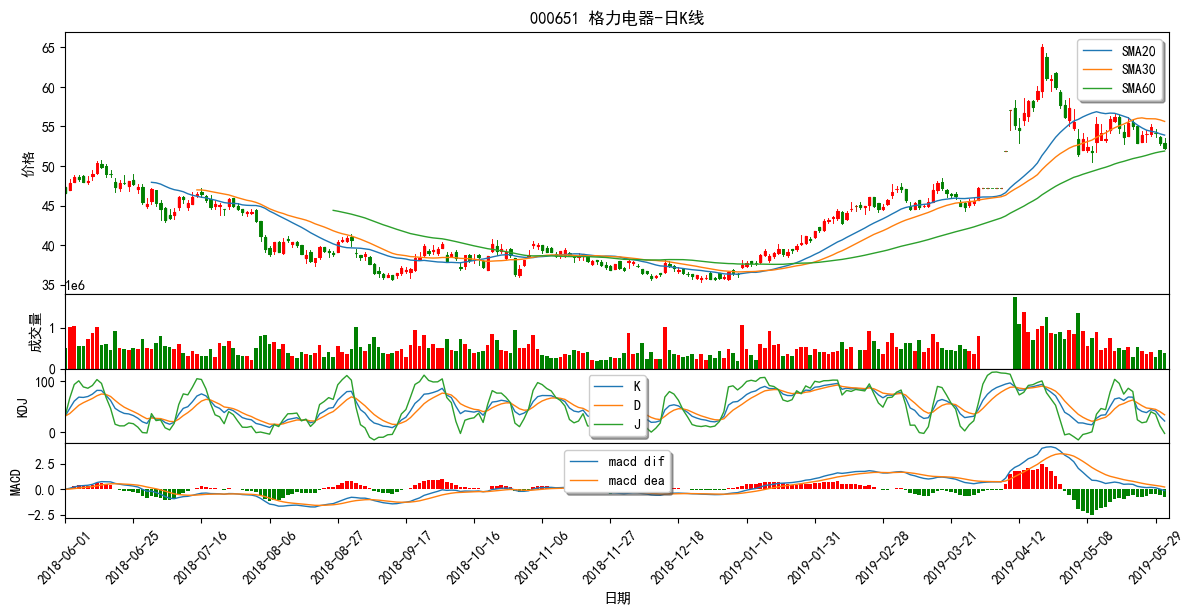

In [42]:
draw_stock = MultiGraphIf(**layout_dict)
draw_stock.graph_run(df_stockload, **subplots_dict)